#**Система для сбора событий и логов на тему - "Анализ логов"**
#**Практическая работа №2 по предмету**

Выполнил студент - **Сапов Александр Дмитриевич** группы: **ББМО-02-23**

## **Вариант задания:**

В списке группы - **26**

Расчет варианта - **26 % 16 + 1 = 11**

В качестве логов по варианту - **`OpenStack`** в репозитории **`loghub`**

## **1 - Загрузка файлов из репозитория `loghub` в рабочую область проекта:**

In [15]:
import os.path

if not os.path.isdir("./loghub/"):
    !git clone https://github.com/logpai/loghub

## **2 - Создание регулярного выражения для парсинга логов:**

Для примера возьмем строчку из логов `OpenStack`:

`nova-api.log.1.2017-05-16_13:53:08 2017-05-16 00:00:00.008 25746 INFO nova.osapi_compute.wsgi.server [req-38101a0b-2096-447d-96ea-a692162415ae 113d3a99c3da401fbd62cc2caa5b96d2 54fadb412c4e40cdbaed9335e4c35a9e - - -] 10.11.10.1 "GET /v2/54fadb412c4e40cdbaed9335e4c35a9e/servers/detail HTTP/1.1" status: 200 len: 1893 time: 0.2477829`

Регулярное выражение извлекает все поля записи лога и делит его на следующие группы:

1. (\d{4}-\d{2}-\d{2}\s+\d{2}:\d{2}:\d{2},\d{3}) — дата и время (например, 2017-07-25 01:17:36,490).
2. (\d+) — PID (например, 20582).
3. (\w+) — уровень логирования (например, INFO).
4. ([\w\.]+) — компонент (например, neutron.wsgi).
5. (.*) — остальное сообщение.


**Реализация регулярного выражения:**

In [16]:
pattern = r'^\S+\s+(\d{4}-\d{2}-\d{2}\s+\d{2}:\d{2}:\d{2}\.\d{3})\s+(\d+)\s+(\w+)\s+([\w\.]+)\s+(.*)'

## **3 - Cоздание базы данных для хранения записей полученных логов:**

In [17]:
if not os.path.isdir("./db/"):
  os.makedirs("./db/")

import sqlite3

db_path = './db/log-db.db'
connection = sqlite3.connect(db_path)
cursor = connection.cursor()

cursor.execute("DROP TABLE IF EXISTS logs")
cursor.execute("CREATE TABLE logs (Id INTEGER PRIMARY KEY AUTOINCREMENT, Datetime TEXT, Pid INTEGER, Level TEXT, Component TEXT, Message TEXT)")

connection.commit()
cursor.close()
connection.close()

## **4 - Парсинг логов `OpenStack` и сохранение полученных данных в БД:**

In [28]:
import sqlite3
import re

connection = sqlite3.connect(db_path)
cursor = connection.cursor()

cursor.execute("DELETE FROM logs")

with open('./loghub/OpenStack/OpenStack_2k.log', 'r', encoding='utf-8') as log_file:
    for line in log_file:
        log_match = re.match(pattern, line)
        if log_match:
            datetime = log_match.group(1)
            pid = log_match.group(2)
            level = log_match.group(3)
            component = log_match.group(4)
            message = log_match.group(5)
            values = (datetime, pid, level, component, message)
            sql = "INSERT INTO logs (Datetime, Pid, Level, Component, Message) VALUES (?, ?, ?, ?, ?)"
            cursor.execute(sql, values)
        else:
            print(f"Не удалось распознать строку: {line.strip()}")  # Отладка

connection.commit()
cursor.close()
connection.close()

## **5 - Чтению данных, записанных ранее в БД:**

In [29]:
import pandas as pd

connection = sqlite3.connect(db_path)
cursor = connection.cursor()

cursor.execute("SELECT * FROM logs")
rows = cursor.fetchall()

cursor.close()
connection.close()

log_df = pd.DataFrame(rows, columns=("Id", "Datetime", "Pid", "Level", "Component", "Message"))
log_df

,Id,Datetime,Pid,Level,Component,Message
0,2001,2017-05-16 00:00:00.008,25746,INFO,nova.osapi_compute.wsgi.server,[req-38101a0b-2096-447d-96ea-a692162415ae 113d...
1,2002,2017-05-16 00:00:00.272,25746,INFO,nova.osapi_compute.wsgi.server,[req-9bc36dd9-91c5-4314-898a-47625eb93b09 113d...
2,2003,2017-05-16 00:00:01.551,25746,INFO,nova.osapi_compute.wsgi.server,[req-55db2d8d-cdb7-4b4b-993b-429be84c0c3e 113d...
3,2004,2017-05-16 00:00:01.813,25746,INFO,nova.osapi_compute.wsgi.server,[req-2a3dc421-6604-42a7-9390-a18dc824d5d6 113d...
4,2005,2017-05-16 00:00:03.091,25746,INFO,nova.osapi_compute.wsgi.server,[req-939eb332-c1c1-4e67-99b8-8695f8f1980a 113d...
...,...,...,...,...,...,...
1995,3996,2017-05-16 00:14:47.410,25746,INFO,nova.osapi_compute.wsgi.server,[req-699eeadf-6db8-44a4-8521-1ab4e8a53b53 113d...
1996,3997,2017-05-16 00:14:47.447,2931,INFO,nova.compute.manager,[req-699eeadf-6db8-44a4-8521-1ab4e8a53b53 113d...
1997,3998,2017-05-16 00:14:47.652,25799,INFO,nova.metadata.wsgi.server,[req-e5e061d6-f2aa-464b-9512-2fd6c7c9a812 - - ...
1998,3999,2017-05-16 00:14:47.663,2931,INFO,nova.virt.libvirt.driver,[-] [instance: faf974ea-cba5-4e1b-93f4-3a3bc60...


## **6 - Анализ данных из логов `OpenStack**

На этом этапе выполним базовый анализ логов:
- Подсчет количества записей по уровням логирования (`Level`).
- Определение топ-5 наиболее активных компонентов (`Component`).
- Вывод результатов в виде таблиц.

In [30]:
import pandas as pd
import sqlite3

# Подключаемся к базе данных
connection = sqlite3.connect(db_path)
cursor = connection.cursor()

# Читаем данные
cursor.execute("SELECT * FROM logs")
rows = cursor.fetchall()

cursor.close()
connection.close()

# Создаем DataFrame
log_df = pd.DataFrame(rows, columns=("Id", "Datetime", "Pid", "Level", "Component", "Message"))

# Анализ по уровням логирования
level_counts = log_df['Level'].value_counts()
print("Количество записей по уровням логирования:")
print(level_counts)

# Анализ по компонентам
component_counts = log_df['Component'].value_counts().head(5)
print("\nТоп-5 наиболее активных компонентов:")
print(component_counts)

Количество записей по уровням логирования:
Level
INFO       1969
WARNING      31
Name: count, dtype: int64

Топ-5 наиболее активных компонентов:
Component
nova.osapi_compute.wsgi.server    809
nova.virt.libvirt.imagecache      336
nova.compute.manager              262
nova.metadata.wsgi.server         208
nova.compute.claims               168
Name: count, dtype: int64


## 7 - Визуализация данных из логов `OpenStack`:

Построим столбчатую диаграмму количества записей для уровней логирования `INFO` и `WARNING`.

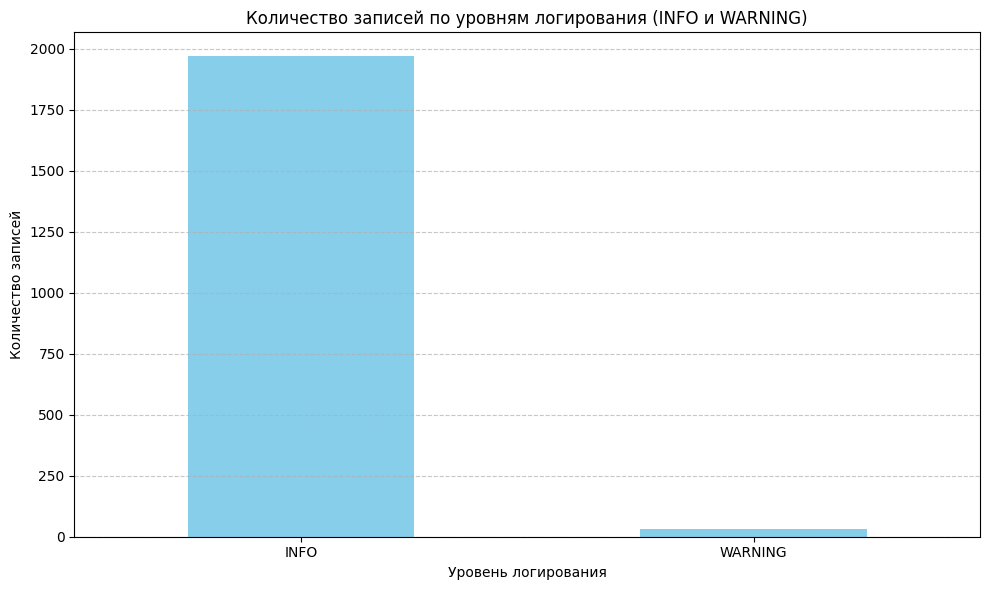

In [34]:
import matplotlib.pyplot as plt

# Фильтруем только INFO и WARNING
filtered_levels = log_df[log_df['Level'].isin(['INFO', 'WARNING'])]
level_counts = filtered_levels['Level'].value_counts()

# Создание столбчатой диаграммы
plt.figure(figsize=(10, 6))
level_counts.plot(kind='bar', color='skyblue')
plt.title('Количество записей по уровням логирования (INFO и WARNING)')
plt.xlabel('Уровень логирования')
plt.ylabel('Количество записей')
plt.xticks(rotation=0)  # Без поворота, так как только 2 значения
plt.grid(axis='y', linestyle='--', alpha=0.7)
plt.tight_layout()
plt.show()

## 8 - Поиск подозрительных событий в логах `OpenStack`:


Выведем первые 5 записей для уровней `INFO` и `WARNING` для анализа.

In [33]:
# Фильтрация записей с уровнем INFO
info_logs = log_df[log_df['Level'] == 'INFO']
print("Первые 5 записей с уровнем INFO:")
if len(info_logs) > 0:
    print(info_logs.head(5))
else:
    print("Записей с уровнем INFO не найдено.")

# Фильтрация записей с уровнем WARNING
warning_logs = log_df[log_df['Level'] == 'WARNING']
print("\nПервые 5 записей с уровнем WARNING:")
if len(warning_logs) > 0:
    print(warning_logs.head(5))
else:
    print("Записей с уровнем WARNING не найдено.")

Первые 5 записей с уровнем INFO:
     Id                 Datetime    Pid Level                       Component  \
0  2001  2017-05-16 00:00:00.008  25746  INFO  nova.osapi_compute.wsgi.server   
1  2002  2017-05-16 00:00:00.272  25746  INFO  nova.osapi_compute.wsgi.server   
2  2003  2017-05-16 00:00:01.551  25746  INFO  nova.osapi_compute.wsgi.server   
3  2004  2017-05-16 00:00:01.813  25746  INFO  nova.osapi_compute.wsgi.server   
4  2005  2017-05-16 00:00:03.091  25746  INFO  nova.osapi_compute.wsgi.server   

                                             Message  
0  [req-38101a0b-2096-447d-96ea-a692162415ae 113d...  
1  [req-9bc36dd9-91c5-4314-898a-47625eb93b09 113d...  
2  [req-55db2d8d-cdb7-4b4b-993b-429be84c0c3e 113d...  
3  [req-2a3dc421-6604-42a7-9390-a18dc824d5d6 113d...  
4  [req-939eb332-c1c1-4e67-99b8-8695f8f1980a 113d...  

Первые 5 записей с уровнем WARNING:
       Id                 Datetime   Pid    Level  \
56   2057  2017-05-16 00:00:20.345  2931  WARNING   
146  21